In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from sklearn.metrics import auc, precision_recall_curve, roc_curve, confusion_matrix, average_precision_score
import os
from tqdm import tqdm
import json
from scipy import interp
import pandas as pd

In [3]:
dataset_counts = [672, 500, 400, 300, 200, 100]
folds = [0, 1, 2, 3, 4]
# init stats dict
stats = {
    d:{
        f: {
            y: [] for y in ["y_true", "y_pred", "y_prob"]} 
        for f in folds} 
    for d in dataset_counts
}

# Read predictions files

In [4]:
for dataset_count in dataset_counts:
    for cur_fold in folds:
        pred_filepath = os.path.join(
            'predictions', 
            'figure_3_dataset_{}'.format(dataset_count), 
            'model_predictions_{}_fold_{}'.format(dataset_count, cur_fold)
        )
        with open(pred_filepath, 'r') as f:
            lines = [l.strip().split(',') for l in f.readlines()]
            
        for l in lines[1:]:
            stats[dataset_count][cur_fold]["y_true"].append(int(l[0]))
            stats[dataset_count][cur_fold]["y_pred"].append(int(l[1]))
            stats[dataset_count][cur_fold]["y_prob"].append(float(l[2]))
            
        stats[dataset_count][cur_fold]["y_true"] = np.array(stats[dataset_count][cur_fold]["y_true"])
        stats[dataset_count][cur_fold]["y_pred"] = np.array(stats[dataset_count][cur_fold]["y_pred"])
        stats[dataset_count][cur_fold]["y_prob"] = np.array(stats[dataset_count][cur_fold]["y_prob"])

# Average Precision for Each Dataset

In [5]:
average_precisions = []
for dataset_count in dataset_counts:
    cur_avg_precisions = []
    for cur_fold in folds:
        average_precision = average_precision_score(
            stats[dataset_count][cur_fold]['y_true'], 
            stats[dataset_count][cur_fold]['y_prob']
        )
        cur_avg_precisions.append(average_precision)
    average_precisions.append(cur_avg_precisions)

    

In [18]:
dataset_counts

[672, 500, 400, 300, 200, 100]

In [21]:
average_precisions.shape

AttributeError: 'list' object has no attribute 'shape'

In [49]:
df = pd.DataFrame({
    "672": average_precisions[0],
    "500": average_precisions[1],
    "400": average_precisions[2],
    "300": average_precisions[3],
    "200": average_precisions[4],
    "100": average_precisions[5],
})

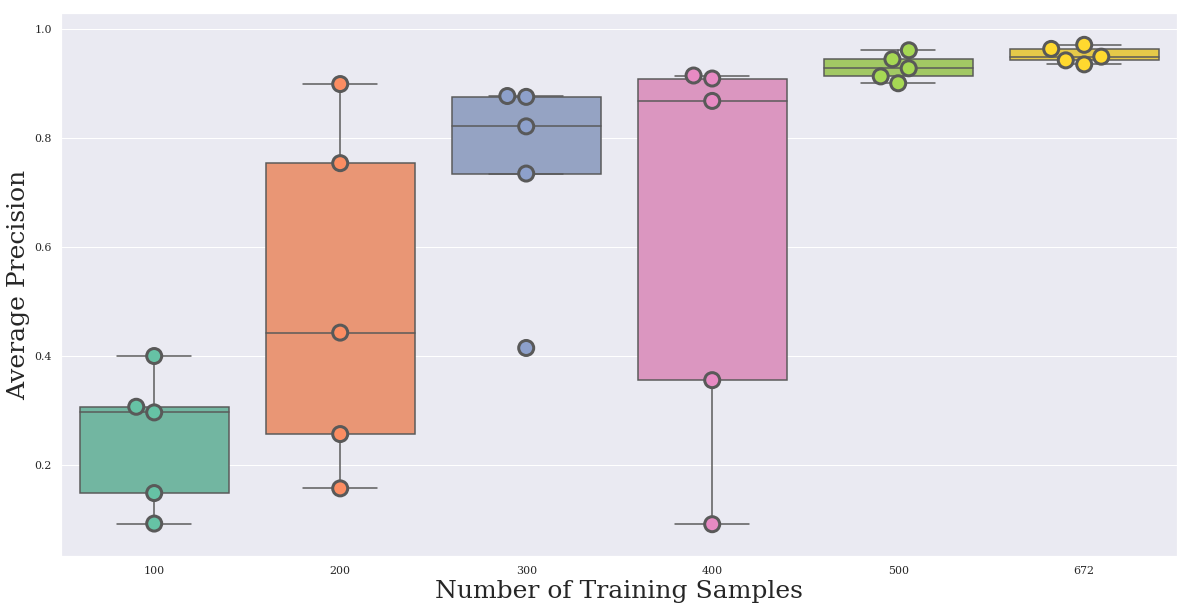

In [69]:
sns.set(rc={'figure.figsize':(20,10), 'font.size': 25, "axes.labelsize":25, 'font.family':'serif'})

sns.boxplot(
    x=dataset_counts, 
    y=average_precisions,
    palette=sns.color_palette("Set2", n_colors=6, desat=1)
).set(
    xlabel='Number of Training Samples', 
    ylabel='Average Precision',
)


sns.swarmplot(
    data=df,
    palette=sns.color_palette("Set2", n_colors=6, desat=1),
    size=15,
    linewidth=3,
)

plt.savefig(os.path.join("figures", "figure_6_average_precision_by_dataset_count_with_swarm.png"))

plt.show()

# Precision-Recall Curve

In [91]:
interp?

In [101]:
def get_CI(y_true, y_pred):
    n_bootstraps = 100
    rng_seed = 100
    precisions = []
    aps = []
    mean_recall = np.linspace(0, 1, 1000)
    rng = np.random.RandomState(rng_seed)
    
    for _ in range(n_bootstraps):
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))

        precision, recall, thresholds = precision_recall_curve(y_true[indices], y_pred[indices])
        precisions.append(interp(mean_recall, recall, precision))
        precisions[-1][0] = 1.0
        aps.append(average_precision_score(y_true[indices], y_pred[indices]))
        
    mean_precisions = np.mean(precisions, axis=0)
    mean_precisions[-1] = 0.0
    mean_ap = average_precision_score(mean_precisions, mean_recall)
    std_ap = np.std(aps)
    std_precision = np.std(precisions, axis=0)
    
    print(mean_precisions)
    print(std_precision)
    precisions_upper = np.minimum(mean_precisions + std_precision, 1)
    precisions_lower = np.maximum(mean_precisions - std_precision, 0)
    
    return mean_ap, std_ap, mean_precisions, mean_recall, precisions_upper, precisions_lower

In [102]:
# concatenate all fold predictions into one list
cat_stats = {
    d:{
        y: [] for y in ["y_true", "y_pred", "y_prob"]} 
    for d in dataset_counts
}
for dataset_count in dataset_counts:
    for cur_fold in range(5):
        cat_stats[dataset_count]['y_true'].extend(stats[dataset_count][cur_fold]['y_true'])
        cat_stats[dataset_count]['y_prob'].extend(stats[dataset_count][cur_fold]['y_prob'])
        
    cat_stats[dataset_count]['y_true'] = np.array(cat_stats[dataset_count]['y_true'])
    cat_stats[dataset_count]['y_prob'] = np.array(cat_stats[dataset_count]['y_prob'])

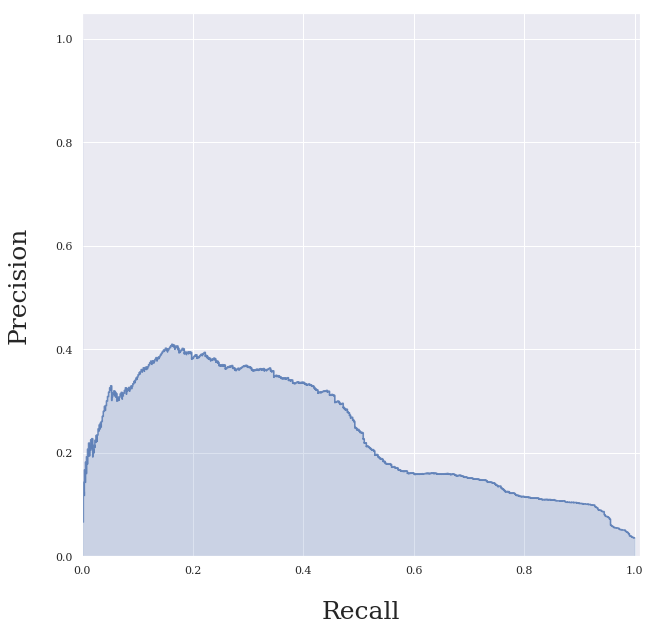

In [103]:
precision, recall, thresholds = precision_recall_curve(
    cat_stats[100]['y_true'], 
    cat_stats[100]['y_prob']  
)

average_precision = average_precision_score(    
    cat_stats[100]['y_true'], 
    cat_stats[100]['y_prob']
)

plt.figure(figsize=(10, 10))


step_kwargs = {'step': 'post'}
plt.step(recall, precision, color='b', alpha=0.8, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall', labelpad=25)
plt.ylabel('Precision', labelpad=25)
plt.ylim([0, 1.05])
plt.xlim([0, 1.01])
plt.show()

/home-local/remedis/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 40419 + 1) instead
  # Remove the CWD from sys.path while we load stuff.


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

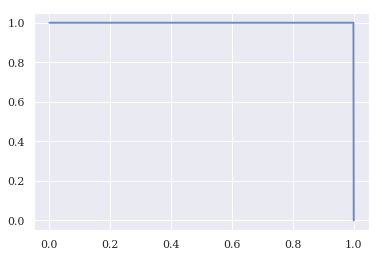

In [104]:
mean_ap, st_ap, mean_p, mean_r, p_up, p_lo = get_CI(
    cat_stats[100]['y_true'], 
    cat_stats[100]['y_prob']
)

plt.plot(mean_r, mean_p, lw=2, alpha=.8)
plt.fill_between(mean_r, p_lo, p_up, alpha=.2)
    


/home-local/remedis/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 40419 + 1) instead
  # Remove the CWD from sys.path while we load stuff.


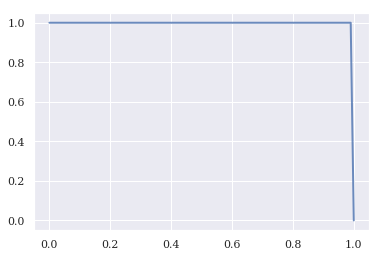

In [74]:
for dataset_count in dataset_counts:
    mean_ap, st_ap, mean_p, mean_r, p_up, p_lo = get_CI(
        cat_stats[dataset_count]['y_true'], 
        cat_stats[dataset_count]['y_prob']
    )

    plt.plot(mean_r, mean_p, lw=2, alpha=.8)
    #plt.fill_between(mean_r, p_lo, p_up, alpha=.2)
    
    break

In [124]:
p, r, t = precision_recall_curve(
    stats[672][2]["y_true"],
    stats[672][2]["y_prob"],
)

In [128]:
p.std()

0.21815759413754374

In [129]:
p, r, t = precision_recall_curve(
    stats[672][1]["y_true"],
    stats[672][1]["y_prob"],
)

In [130]:
p.std()

0.2587696273514676

In [94]:
precision_recall_curve?

In [ ]:
for dataset_count in dataset_counts:
    ps, rs, ts = [], [], []
    for cur_fold in folds:
        p, r, t = precision_recall_curve(
            stats[dataset_count][cur_fold]["y_true"],
            stats[dataset_count][cur_fold]["y_prob"],
        )
        ps.append(p)
        rs.append(r)
        ts.append(t)
        
    precision = np.mean(ps)

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    average_precision = average_precision_score(y_true, y_prob)

    step_kwargs = {'step': 'post'}
    plt.plot(recall, precision, label='Model {}'.format(dataset_count))
    #plt.step(recall, precision, color='b', alpha=0.2, where='post')
    #plt.fill_between(recall, precision, alpha=0.1, **step_kwargs)

    plt.xlabel('Recall', labelpad=25)
    plt.ylabel('Precision', labelpad=25)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.01])
    
plt.legend()

plt.savefig('figures/figure_4_pr_curve_comparison.png', bbox_inches='tight')
plt.savefig('figures/figure_4_pr_curve_comparison.eps', bbox_inches='tight')

In [83]:
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

average_precision = average_precision_score(y_true, y_prob)

plt.figure(figsize=(10, 10))


step_kwargs = {'step': 'post'}
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall', labelpad=25)
plt.ylabel('Precision', labelpad=25)
plt.ylim([0, 1.05])
plt.xlim([0, 1.01])
#plt.title('Precision-Recall Curve: AP={0:0.4f}\n'.format(average_precision))
#plt.title('Precision-Recall Curve: Model 672\n'.format(dataset_count))
plt.savefig('figures/figure_3_dataset_{}/dataset_{}_PR_Curve.png'.format(dataset_count, dataset_count), bbox_inches='tight')
plt.savefig('figures/figure_3_dataset_{}/dataset_{}_PR_Curve.eps'.format(dataset_count, dataset_count), bbox_inches='tight')

NameError: name 'y_true' is not defined

# Confusion Matrix

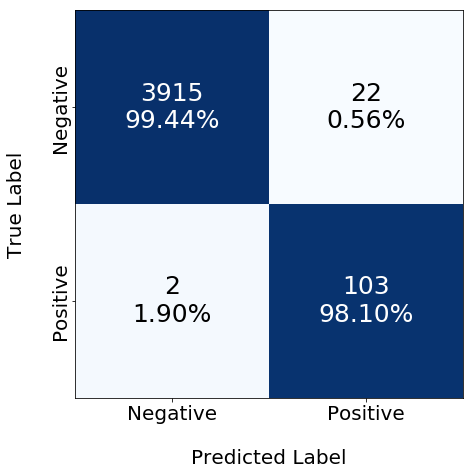

In [12]:
class_names = ['Negative', 'Positive']
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=class_names,
    yticklabels=class_names,
    #title='Model {} Confusion Matrix\n'.format(dataset_count),
    ylabel='True Label',
    xlabel='Predicted Label',
)

ax.xaxis.labelpad = 25
ax.yaxis.labelpad = 25

#plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), rotation=90, ha='center', rotation_mode='anchor')

thresh = cm_norm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, "{}\n{:.2f}%".format(cm[i, j], cm_norm[i, j] * 100),
                ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else 'black',
                fontsize=25)
fig.tight_layout()
plt.savefig('figures/figure_3_dataset_{}/dataset_{}_Normalized_Confusion_Matrix.png'.format(dataset_count, dataset_count), bbox_inches='tight')
plt.savefig('figures/figure_3_dataset_{}/dataset_{}_Normalized_Confusion_Matrix.eps'.format(dataset_count, dataset_count), bbox_inches='tight')

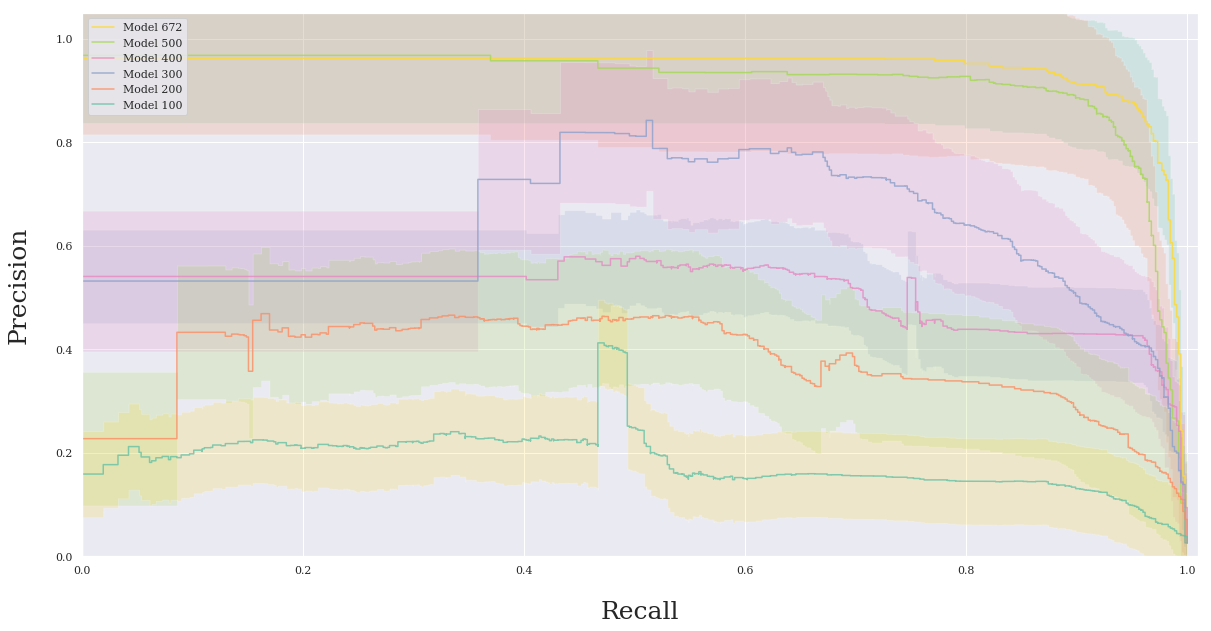

<Figure size 432x288 with 0 Axes>

In [141]:
dataset_counts = [672, 500, 400, 300, 200, 100]
manual_thresholds = np.linspace(0, 1, 1000)

fig = plt.figure(figsize=(20, 10))
plt.xlabel('Recall', labelpad=25)
plt.ylabel('Precision', labelpad=25)
#plt.title('Precision-Recall Curves\n')

colors = sns.color_palette("Set2", n_colors=6, desat=1)[::-1]

for i, dataset_count in enumerate(dataset_counts):

    mean_precision = []
    mean_recall = []
    stds = []
    
    for t in manual_thresholds:
        manual_precision = []
        manual_recall = []
        
        for cur_fold in range(5): 
            
            y_true = []
            y_pred = []
            y_prob = []

            pred_filepath = os.path.join(
                'figures', 
                'figure_3_dataset_{}'.format(dataset_count), 
                'model_predictions_{}_fold_{}'.format(dataset_count, cur_fold)
            )
            with open(pred_filepath, 'r') as f:
                lines = [l.strip().split(',') for l in f.readlines()]
            for l in lines[1:]:
                y_true.append(int(l[0]))
                y_pred.append(int(l[1]))
                y_prob.append(float(l[2]))

            #precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
            #average_precision = average_precision_score(y_true, y_prob)

            num_tp = 0
            num_fp = 0
            num_tn = 0
            num_fn = 0

            for yt, yp in zip(y_true, y_prob):
                if yp > t:
                    thresh_y = 1
                else:
                    thresh_y = 0
                    
                if yt == 0 and thresh_y == 0:
                    num_tn += 1
                elif yt == 0 and thresh_y == 1:
                    num_fp += 1
                elif yt == 1 and thresh_y == 1:
                    num_tp += 1
                elif yt == 1 and thresh_y == 0:
                    num_fn += 1
                    
            if num_tp == 0:
                manual_precision.append(0)
                manual_recall.append(0)
            else:    
                manual_precision.append(num_tp/(num_tp+num_fp))
                manual_recall.append(num_tp/(num_tp+num_fn))
                
            
        mean_precision.append(np.mean(manual_precision))
        mean_recall.append(np.mean(manual_recall))
    
    
    std = np.std(mean_precision, axis=0)
    step_kwargs = {'step': 'post'}
    #plt.plot(mean_recall, mean_precision, label='Model {}'.format(dataset_count))
    plt.step(mean_recall, mean_precision, color=colors[i], alpha=0.8, where='post', label='Model {}'.format(dataset_count), )
    plt.fill_between(mean_recall, mean_precision - std, mean_precision + std, alpha=0.2, **step_kwargs)

    plt.legend()
    plt.xlabel('Recall', labelpad=25)
    plt.ylabel('Precision', labelpad=25)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.01])
    
plt.show()


plt.savefig('figures/figure_7_pr_curve_comparison.png', bbox_inches='tight')
plt.savefig('figures/figure_7_pr_curve_comparison.eps', bbox_inches='tight')

In [4]:
len(thresholds)

14728

In [137]:
len(sns.color_palette())

6